In [1]:
# Import
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import resample
from wfdb import processing
from sklearn import preprocessing

import csv
import math
import scipy.fftpack    
import scipy.signal as signal                               

### **ECG Signals**

Infant 1

In [2]:
# read data  
data_dir = "C:/Users/bai/Desktop/database"
ecg1_record = wfdb.rdsamp(f"{data_dir}/infant1_ecg")
#plt.plot(ecg1_record[:1000])

ecg1_resampled = resample(ecg1_record[0], int(len(ecg1_record[0])*50/250))  # ECG resampled to 50Hz
# plt.plot(ecg1_resampled[:1000])  
ecg1_resampled = preprocessing.scale(ecg1_resampled)  #Z-score


In [8]:
df1 = pd.DataFrame(ecg1_resampled)
#df1 = pd.DataFrame(ecg1_resampled[20000:21000])
df1.insert(0, 'timestamp', np.arange(0, len(df1)*0.02, 0.02))

df1.columns = ["time", "ECG"]
df1.insert(0, "sample", range(1, len(df1) + 1))

df1.to_csv('C:/Users/bai/Desktop/ecg1_resampled.csv',index=False)

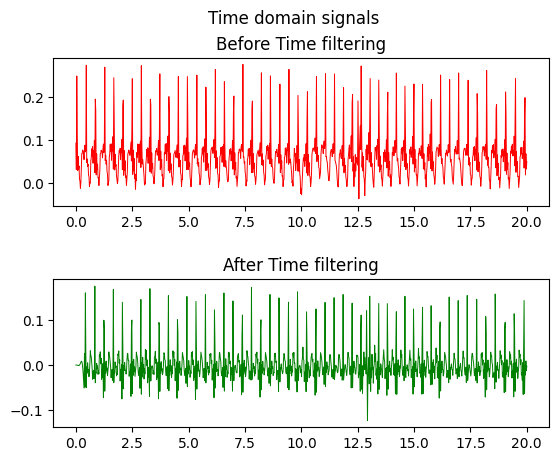

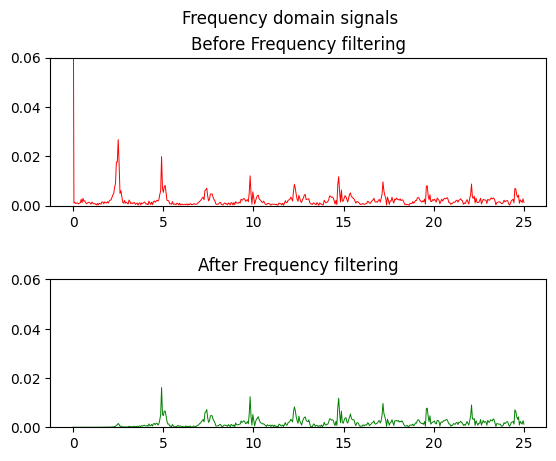

In [9]:
                  
###Obtain ecg sample from csv file using pandas###

dataset = pd.read_csv("ecg1_resampled.csv")
y = dataset.iloc[:,2].values

# Number of samplepoints
N = len(y)
# sample spacing
Fs = 50
T = 1.0 / Fs
#Compute x-axis
x = np.linspace(0.0, N*T, N)

#Compute FFT
yf = scipy.fftpack.fft(y)
#Compute frequency x-axis
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

###Declare plots for time-domain and frequency-domain plots##
fig_td = plt.figure(dpi=100)
ax1 = fig_td.add_subplot(211)
ax1.set_title('Before Time filtering')
ax2 = fig_td.add_subplot(212)
ax2.set_title('After Time filtering')
fig_td.suptitle("Time domain signals")

ax1.plot(x,y, color='r', linewidth=0.7)
fig_td.subplots_adjust(hspace=0.5)


fig_fd = plt.figure(dpi=100)
ax3 = fig_fd.add_subplot(211)
ax3.set_title('Before Frequency filtering')
ax4 = fig_fd.add_subplot(212)
ax4.set_title('After Frequency filtering')
fig_fd.suptitle("Frequency domain signals")

ax3.plot(xf, 2.0/N * np.abs(yf[:N//2]), color='r', linewidth=0.7, label='raw')
ax3.set_ylim([0 , 0.06])

fig_fd.subplots_adjust(hspace=0.5)

#### Compute Kaiser window co-effs to eliminate baseline drift noise ###
nyq_rate = Fs/ 2.0
# The desired width of the transition from pass to stop.
width = 5.0/nyq_rate
# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
# Compute the order and Kaiser parameter for the FIR filter.
O, beta = signal.kaiserord(ripple_db, width)
# The cutoff frequency of the filter.
cutoff_hz = 4.0
####Use firwin with a Kaiser window to create a lowpass FIR filter.###
taps = signal.firwin(O+1, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
# Use lfilter to filter x with the FIR filter.
y_filt = signal.lfilter(taps, 1.0, y) #tempf
yff = scipy.fftpack.fft(y_filt)
#Plot filtered outputs
ax4.plot(xf, 2.0/N * np.abs(yff[:N//2]), color='g', linewidth=0.7)
ax4.set_ylim([0 , 0.06])
ax2.plot(x,y_filt, color='g', linewidth=0.7)




Average Heart Beat is: 151.2

No of peaks in sample are 50


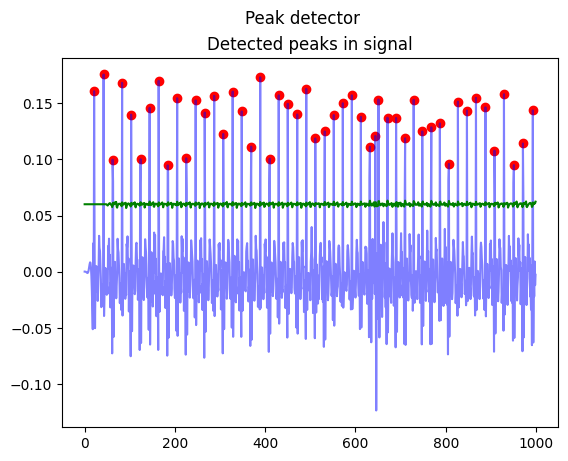

In [10]:
dataset['filt']=y_filt
#Calculate moving average with time in both directions, then append do dataset
hrw = 1 #One-sided window size, as proportion of the sampling frequency
fs = 50 #The example dataset was recorded at 50Hz
mov_avg = dataset.filt.rolling(int(hrw * fs)).mean()  #Calculate moving average

#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(dataset.filt)) 
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [(0.05+x) for x in mov_avg]

mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
dataset['filt_rollingmean'] = mov_avg #Append the moving average to the dataframe

#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in dataset.filt:
    rollingmean = dataset.filt_rollingmean[listpos] #Get local mean
    
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1

    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
        
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1

ybeat = [dataset.filt[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

fig_hr= plt.figure(dpi=100)
fig_hr.suptitle('Peak detector')
ax5 = fig_hr.add_subplot(111)
ax5.set_title("Detected peaks in signal")
ax5.plot(dataset.filt, alpha=0.5, color='blue') #Plot semi-transparent HR
ax5.plot(mov_avg, color ='green') #Plot moving average
ax5.scatter(peaklist, ybeat, color='red') #Plot detected peaks


#Compute heart rate
RR_list = []
cnt = 0
while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1

bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
print("\n\n\nAverage Heart Beat is: %.01f\n" %(bpm)) #Round off to 1 decimal and print
print("No of peaks in sample are {0}".format(len(peaklist)))
#print("peaklist", peaklist)

heart_rate_list = []
for i in range(len(RR_list)):
    heart_rate = 60000 / RR_list[i]
    heart_rate_list.append(heart_rate)
#print("heart_rate", heart_rate_list)


plt.show()


In [11]:
df_peaklist = pd.DataFrame(peaklist)
df_heart_rate = pd.DataFrame(heart_rate_list)
df_heart_rate1 = pd.concat([df_peaklist, df_heart_rate], axis=1)
df_heart_rate1.columns = ["sample", "heart_rate"]
df_heart_rate1 = df_heart_rate1[(df_heart_rate1['heart_rate'] > 100) & (df_heart_rate1['heart_rate'] < 180)]  #Delete abnormal data

df_heart_rate1.to_csv('C:/Users/bai/Desktop/heart_rate1.csv',index=False)


Infant 2

In [ ]:
# read data   
data_dir = "C:/Users/bai/Desktop/database"
ecg2_record = wfdb.rdsamp(f"{data_dir}/infant2_ecg")
ecg2_resampled = resample(ecg2_record[0], int(len(ecg2_record[0])*50/500)) # ECG resampled to 50Hz
ecg2_resampled = preprocessing.scale(ecg2_resampled)  #Z-score

df2 = pd.DataFrame(ecg2_resampled)
df2.insert(0, 'timestamp', np.arange(0, len(df2)*0.02, 0.02))
df2.columns = ["time", "ECG"]
df2.insert(0, "sample", range(1, len(df2) + 1))
df2.to_csv('C:/Users/bai/Desktop/ecg2_resampled.csv',index=False)

###Obtain ecg sample from csv file using pandas###
dataset = pd.read_csv("C:/Users/bai/Desktop/ecg2_resampled.csv")
y = dataset.iloc[:,2].values

# Number of samplepoints
N = len(y)
# sample spacing
Fs = 50
T = 1.0 / Fs
#Compute x-axis
x = np.linspace(0.0, N*T, N)

#Compute FFT
yf = scipy.fftpack.fft(y)
#Compute frequency x-axis
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

#### Compute Kaiser window co-effs to eliminate baseline drift noise ###
nyq_rate = Fs/ 2.0
# The desired width of the transition from pass to stop.
width = 5.0/nyq_rate
# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
# Compute the order and Kaiser parameter for the FIR filter.
O, beta = signal.kaiserord(ripple_db, width)
# The cutoff frequency of the filter.
cutoff_hz = 4.0
####Use firwin with a Kaiser window to create a lowpass FIR filter.###
taps = signal.firwin(O+1, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
# Use lfilter to filter x with the FIR filter.
y_filt = signal.lfilter(taps, 1.0, y) #tempf
yff = scipy.fftpack.fft(y_filt)


dataset['filt']=y_filt
#Calculate moving average with time in both directions, then append do dataset
hrw = 1 #One-sided window size, as proportion of the sampling frequency
fs = 50 #The example dataset was recorded at 50Hz
mov_avg = dataset.filt.rolling(int(hrw * fs)).mean()  #Calculate moving average

#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(dataset.filt)) 
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [(0.5+x) for x in mov_avg]

mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
dataset['filt_rollingmean'] = mov_avg #Append the moving average to the dataframe

#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in dataset.filt:
    rollingmean = dataset.filt_rollingmean[listpos] #Get local mean
    
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1

    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
        
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1

ybeat = [dataset.filt[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

fig_hr= plt.figure(dpi=100)
fig_hr.suptitle('Peak detector')
ax5 = fig_hr.add_subplot(111)
ax5.set_title("Detected peaks in signal")
ax5.plot(dataset.filt, alpha=0.5, color='blue') #Plot semi-transparent HR
ax5.plot(mov_avg, color ='green') #Plot moving average
ax5.scatter(peaklist, ybeat, color='red') #Plot detected peaks

#Compute heart rate
RR_list = []
cnt = 0
while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1

bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
#print("\n\n\nAverage Heart Beat is: %.01f\n" %(bpm)) #Round off to 1 decimal and print
print("No of peaks in sample are {0}".format(len(peaklist)))
#print("peaklist", peaklist)

heart_rate_list = []
for i in range(len(RR_list)):
    heart_rate = 60000 / RR_list[i]
    heart_rate_list.append(heart_rate)
#print("heart_rate", heart_rate_list)


plt.show()

df_peaklist = pd.DataFrame(peaklist)
df_heart_rate = pd.DataFrame(heart_rate_list)
df_heart_rate2 = pd.concat([df_peaklist, df_heart_rate], axis=1)
df_heart_rate2.columns = ["sample", "heart_rate"]
df_heart_rate2 = df_heart_rate2[(df_heart_rate2['heart_rate'] > 100) & (df_heart_rate2['heart_rate'] < 180)] #Delete abnormal data

df_heart_rate2.to_csv('C:/Users/bai/Desktop/heart_rate2.csv',index=False)


Infant 3

In [ ]:
# read data
data_dir = "C:/Users/bai/Desktop/database"
ecg3_record = wfdb.rdsamp(f"{data_dir}/infant3_ecg")
ecg3_resampled = resample(ecg3_record[0], int(len(ecg3_record[0])*50/500)) # ECG resampled to 50Hz
ecg3_resampled = preprocessing.scale(ecg3_resampled)  #Z-score

df3 = pd.DataFrame(ecg3_resampled)
df3.insert(0, 'timestamp', np.arange(0, len(df3)*0.02, 0.02))
df3.columns = ["time", "ECG"]
df3.insert(0, "sample", range(1, len(df3) + 1))
df3.to_csv('C:/Users/bai/Desktop/ecg3_resampled.csv',index=False)
                                                   
###Obtain ecg sample from csv file using pandas###
dataset = pd.read_csv("ecg3_resampled.csv")
y = dataset.iloc[:,2].values

# Number of samplepoints
N = len(y)
# sample spacing
Fs = 50
T = 1.0 / Fs
#Compute x-axis
x = np.linspace(0.0, N*T, N)

#Compute FFT
yf = scipy.fftpack.fft(y)
#Compute frequency x-axis
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

#### Compute Kaiser window co-effs to eliminate baseline drift noise ###
nyq_rate = Fs/ 2.0
# The desired width of the transition from pass to stop.
width = 5.0/nyq_rate
# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
# Compute the order and Kaiser parameter for the FIR filter.
O, beta = signal.kaiserord(ripple_db, width)
# The cutoff frequency of the filter.
cutoff_hz = 4.0
####Use firwin with a Kaiser window to create a lowpass FIR filter.###
taps = signal.firwin(O+1, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
# Use lfilter to filter x with the FIR filter.
y_filt = signal.lfilter(taps, 1.0, y) #tempf
yff = scipy.fftpack.fft(y_filt)


dataset['filt']=y_filt
#Calculate moving average with 0.75s in both directions, then append do dataset
hrw = 1 #One-sided window size, as proportion of the sampling frequency
fs = 50 #The example dataset was recorded at 50Hz
mov_avg = dataset.filt.rolling(int(hrw * fs)).mean()  #Calculate moving average

#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(dataset.filt)) 
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [(0.5+x) for x in mov_avg]

mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
dataset['filt_rollingmean'] = mov_avg #Append the moving average to the dataframe

#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in dataset.filt:
    rollingmean = dataset.filt_rollingmean[listpos] #Get local mean
    
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1

    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
        
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1

ybeat = [dataset.filt[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

fig_hr= plt.figure(dpi=100)
fig_hr.suptitle('Peak detector')
ax5 = fig_hr.add_subplot(111)
ax5.set_title("Detected peaks in signal")
ax5.plot(dataset.filt, alpha=0.5, color='blue') #Plot semi-transparent HR
ax5.plot(mov_avg, color ='green') #Plot moving average
ax5.scatter(peaklist, ybeat, color='red') #Plot detected peaks


#Compute heart rate
RR_list = []
cnt = 0
while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1

bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
#print("\n\n\nAverage Heart Beat is: %.01f\n" %(bpm)) #Round off to 1 decimal and print
print("No of peaks in sample are {0}".format(len(peaklist)))
#print("peaklist", peaklist)

heart_rate_list = []
for i in range(len(RR_list)):
    heart_rate = 60000 / RR_list[i]
    heart_rate_list.append(heart_rate)
#print("heart_rate", heart_rate_list)


plt.show()

df_peaklist = pd.DataFrame(peaklist)
df_heart_rate = pd.DataFrame(heart_rate_list)
df_heart_rate3 = pd.concat([df_peaklist, df_heart_rate], axis=1)
df_heart_rate3.columns = ["sample", "heart_rate"]
df_heart_rate3 = df_heart_rate3[(df_heart_rate3['heart_rate'] > 100) & (df_heart_rate3['heart_rate'] < 180)] #Delete abnormal data

df_heart_rate3.to_csv('C:/Users/bai/Desktop/heart_rate3.csv',index=False)


Infant 4

In [ ]:
# read data
data_dir = "C:/Users/bai/Desktop/database"
ecg4_record = wfdb.rdsamp(f"{data_dir}/infant4_ecg")
ecg4_resampled = resample(ecg4_record[0], int(len(ecg4_record[0])*50/500)) # ECG resampled to 50Hz
ecg4_resampled = preprocessing.scale(ecg4_resampled)  #Z-score

df4 = pd.DataFrame(ecg4_resampled)
df4.insert(0, 'timestamp', np.arange(0, len(df4)*0.02, 0.02))
df4.columns = ["time", "ECG"]
df4.insert(0, "sample", range(1, len(df4) + 1))
df4.to_csv('C:/Users/bai/Desktop/ecg4_resampled.csv',index=False)
                                                   
###Obtain ecg sample from csv file using pandas###
dataset = pd.read_csv("ecg4_resampled.csv")
y = dataset.iloc[:,2].values

# Number of samplepoints
N = len(y)
# sample spacing
Fs = 50
T = 1.0 / Fs
#Compute x-axis
x = np.linspace(0.0, N*T, N)

#Compute FFT
yf = scipy.fftpack.fft(y)
#Compute frequency x-axis
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

#### Compute Kaiser window co-effs to eliminate baseline drift noise ###
nyq_rate = Fs/ 2.0
# The desired width of the transition from pass to stop.
width = 5.0/nyq_rate
# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
# Compute the order and Kaiser parameter for the FIR filter.
O, beta = signal.kaiserord(ripple_db, width)
# The cutoff frequency of the filter.
cutoff_hz = 4.0
####Use firwin with a Kaiser window to create a lowpass FIR filter.###
taps = signal.firwin(O+1, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
# Use lfilter to filter x with the FIR filter.
y_filt = signal.lfilter(taps, 1.0, y) #tempf
yff = scipy.fftpack.fft(y_filt)


dataset['filt']=y_filt
#Calculate moving average with time in both directions, then append do dataset
hrw = 1 #One-sided window size, as proportion of the sampling frequency
fs = 50 #The example dataset was recorded at 50Hz
mov_avg = dataset.filt.rolling(int(hrw * fs)).mean()  #Calculate moving average

#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(dataset.filt)) 
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [(0.55+x) for x in mov_avg]

mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
dataset['filt_rollingmean'] = mov_avg #Append the moving average to the dataframe

#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in dataset.filt:
    rollingmean = dataset.filt_rollingmean[listpos] #Get local mean
    
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1

    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
        
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1

ybeat = [dataset.filt[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

fig_hr= plt.figure(dpi=100)
fig_hr.suptitle('Peak detector')
ax5 = fig_hr.add_subplot(111)
ax5.set_title("Detected peaks in signal")
ax5.plot(dataset.filt, alpha=0.5, color='blue') #Plot semi-transparent HR
ax5.plot(mov_avg, color ='green') #Plot moving average
ax5.scatter(peaklist, ybeat, color='red') #Plot detected peaks


#Compute heart rate
RR_list = []
cnt = 0
while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1

bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
#print("\n\n\nAverage Heart Beat is: %.01f\n" %(bpm)) #Round off to 1 decimal and print
print("No of peaks in sample are {0}".format(len(peaklist)))
#print("peaklist", peaklist)

heart_rate_list = []
for i in range(len(RR_list)):
    heart_rate = 60000 / RR_list[i]
    heart_rate_list.append(heart_rate)
#print("heart_rate", heart_rate_list)


plt.show()

df_peaklist = pd.DataFrame(peaklist)
df_heart_rate = pd.DataFrame(heart_rate_list)
df_heart_rate4 = pd.concat([df_peaklist, df_heart_rate], axis=1)
df_heart_rate4.columns = ["sample", "heart_rate"]
df_heart_rate4 = df_heart_rate4[(df_heart_rate4['heart_rate'] > 100) & (df_heart_rate4['heart_rate'] < 180)] #Delete abnormal data

df_heart_rate4.to_csv('C:/Users/bai/Desktop/heart_rate4.csv',index=False)


Infant 5

In [ ]:
# read data
data_dir = "C:/Users/bai/Desktop/database"
ecg5_record = wfdb.rdsamp(f"{data_dir}/infant5_ecg")
ecg5_resampled = resample(ecg5_record[0], int(len(ecg5_record[0])*50/250))  # ECG resampled to 50Hz
ecg5_resampled = preprocessing.scale(ecg5_resampled)  #Z-score

df5 = pd.DataFrame(ecg5_resampled)
df5.insert(0, 'timestamp', np.arange(0, len(df5)*0.02, 0.02))
df5.columns = ["time", "ECG"]
df5.insert(0, "sample", range(1, len(df5) + 1))
df5.to_csv('C:/Users/bai/Desktop/ecg5_resampled.csv',index=False)
                                                   
###Obtain ecg sample from csv file using pandas###
dataset = pd.read_csv("ecg5_resampled.csv")
y = dataset.iloc[:,2].values

# Number of samplepoints
N = len(y)
# sample spacing
Fs = 50
T = 1.0 / Fs
#Compute x-axis
x = np.linspace(0.0, N*T, N)

#Compute FFT
yf = scipy.fftpack.fft(y)
#Compute frequency x-axis
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

#### Compute Kaiser window co-effs to eliminate baseline drift noise ###
nyq_rate = Fs/ 2.0
# The desired width of the transition from pass to stop.
width = 5.0/nyq_rate
# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
# Compute the order and Kaiser parameter for the FIR filter.
O, beta = signal.kaiserord(ripple_db, width)
# The cutoff frequency of the filter.
cutoff_hz = 4.0
####Use firwin with a Kaiser window to create a lowpass FIR filter.###
taps = signal.firwin(O+1, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
# Use lfilter to filter x with the FIR filter.
y_filt = signal.lfilter(taps, 1.0, y) #tempf
yff = scipy.fftpack.fft(y_filt)


dataset['filt']=y_filt
#Calculate moving average with time in both directions, then append do dataset
hrw = 1 #One-sided window size, as proportion of the sampling frequency
fs = 50 #The example dataset was recorded at 50Hz
mov_avg = dataset.filt.rolling(int(hrw * fs)).mean()  #Calculate moving average

#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(dataset.filt)) 
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [(0.03+x) for x in mov_avg]

mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
dataset['filt_rollingmean'] = mov_avg #Append the moving average to the dataframe

#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in dataset.filt:
    rollingmean = dataset.filt_rollingmean[listpos] #Get local mean
    
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1

    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
        
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1

ybeat = [dataset.filt[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

fig_hr= plt.figure(dpi=100)
fig_hr.suptitle('Peak detector')
ax5 = fig_hr.add_subplot(111)
ax5.set_title("Detected peaks in signal")
ax5.plot(dataset.filt, alpha=0.5, color='blue') #Plot semi-transparent HR
ax5.plot(mov_avg, color ='green') #Plot moving average
ax5.scatter(peaklist, ybeat, color='red') #Plot detected peaks


#Compute heart rate
RR_list = []
cnt = 0
while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1

bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
#print("\n\n\nAverage Heart Beat is: %.01f\n" %(bpm)) #Round off to 1 decimal and print
print("No of peaks in sample are {0}".format(len(peaklist)))
#print("peaklist", peaklist)

heart_rate_list = []
for i in range(len(RR_list)):
    heart_rate = 60000 / RR_list[i]
    heart_rate_list.append(heart_rate)
#print("heart_rate", heart_rate_list)


plt.show()

df_peaklist = pd.DataFrame(peaklist)
df_heart_rate = pd.DataFrame(heart_rate_list)
df_heart_rate5 = pd.concat([df_peaklist, df_heart_rate], axis=1)
df_heart_rate5.columns = ["sample", "heart_rate"]
df_heart_rate5 = df_heart_rate5[(df_heart_rate5['heart_rate'] > 100) & (df_heart_rate5['heart_rate'] < 180)]  #Delete abnormal data

df_heart_rate5.to_csv('C:/Users/bai/Desktop/heart_rate5.csv',index=False)


Infant 6

In [ ]:
# read data
data_dir = "C:/Users/bai/Desktop/database"
ecg6_record = wfdb.rdsamp(f"{data_dir}/infant6_ecg")
ecg6_resampled = resample(ecg6_record[0], int(len(ecg6_record[0])*50/500))   # ECG resampled to 50Hz
ecg6_resampled = preprocessing.scale(ecg6_resampled)  #Z-score

df6 = pd.DataFrame(ecg6_resampled)
df6.insert(0, 'timestamp', np.arange(0, len(df6)*0.02, 0.02))
df6.columns = ["time", "ECG"]
df6.insert(0, "sample", range(1, len(df6) + 1))
df6.to_csv('C:/Users/bai/Desktop/ecg6_resampled.csv',index=False)
                                                   
###Obtain ecg sample from csv file using pandas###
dataset = pd.read_csv("ecg6_resampled.csv")
y = dataset.iloc[:,2].values

# Number of samplepoints
N = len(y)
# sample spacing
Fs = 50
T = 1.0 / Fs
#Compute x-axis
x = np.linspace(0.0, N*T, N)

#Compute FFT
yf = scipy.fftpack.fft(y)
#Compute frequency x-axis
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

#### Compute Kaiser window co-effs to eliminate baseline drift noise ###
nyq_rate = Fs/ 2.0
# The desired width of the transition from pass to stop.
width = 5.0/nyq_rate
# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
# Compute the order and Kaiser parameter for the FIR filter.
O, beta = signal.kaiserord(ripple_db, width)
# The cutoff frequency of the filter.
cutoff_hz = 4.0
####Use firwin with a Kaiser window to create a lowpass FIR filter.###
taps = signal.firwin(O+1, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
# Use lfilter to filter x with the FIR filter.
y_filt = signal.lfilter(taps, 1.0, y) #tempf
yff = scipy.fftpack.fft(y_filt)


dataset['filt']=y_filt
#Calculate moving average with time in both directions, then append do dataset
hrw = 1 #One-sided window size, as proportion of the sampling frequency
fs = 50 #The example dataset was recorded at 50Hz
mov_avg = dataset.filt.rolling(int(hrw * fs)).mean()  #Calculate moving average

#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(dataset.filt)) 
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [(0.3+x) for x in mov_avg]

mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
dataset['filt_rollingmean'] = mov_avg #Append the moving average to the dataframe

#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in dataset.filt:
    rollingmean = dataset.filt_rollingmean[listpos] #Get local mean
    
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1

    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
        
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1

ybeat = [dataset.filt[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

fig_hr= plt.figure(dpi=100)
fig_hr.suptitle('Peak detector')
ax5 = fig_hr.add_subplot(111)
ax5.set_title("Detected peaks in signal")
ax5.plot(dataset.filt, alpha=0.5, color='blue') #Plot semi-transparent HR
ax5.plot(mov_avg, color ='green') #Plot moving average
ax5.scatter(peaklist, ybeat, color='red') #Plot detected peaks


#Compute heart rate
RR_list = []
cnt = 0
while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1

bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
#print("\n\n\nAverage Heart Beat is: %.01f\n" %(bpm)) #Round off to 1 decimal and print
print("No of peaks in sample are {0}".format(len(peaklist)))
#print("peaklist", peaklist)

heart_rate_list = []
for i in range(len(RR_list)):
    heart_rate = 60000 / RR_list[i]
    heart_rate_list.append(heart_rate)
#print("heart_rate", heart_rate_list)


plt.show()

df_peaklist = pd.DataFrame(peaklist)
df_heart_rate = pd.DataFrame(heart_rate_list)
df_heart_rate6 = pd.concat([df_peaklist, df_heart_rate], axis=1)
df_heart_rate6.columns = ["sample", "heart_rate"]
df_heart_rate6 = df_heart_rate6[(df_heart_rate6['heart_rate'] > 100) & (df_heart_rate6['heart_rate'] < 180)]   #Delete abnormal data

df_heart_rate6.to_csv('C:/Users/bai/Desktop/heart_rate6.csv',index=False)


Infant 7

In [ ]:
# read data
data_dir = "C:/Users/bai/Desktop/database"
ecg7_record = wfdb.rdsamp(f"{data_dir}/infant7_ecg")
ecg7_resampled = resample(ecg7_record[0], int(len(ecg7_record[0])*50/500))  # ECG resampled to 50Hz
ecg7_resampled = preprocessing.scale(ecg7_resampled)  #Z-score

df7 = pd.DataFrame(ecg7_resampled)
df7.insert(0, 'timestamp', np.arange(0, len(df7)*0.02, 0.02))
df7.columns = ["time", "ECG"]
df7.insert(0, "sample", range(1, len(df7) + 1))
df7.to_csv('C:/Users/bai/Desktop/ecg7_resampled.csv',index=False)
                                                   
###Obtain ecg sample from csv file using pandas###
dataset = pd.read_csv("ecg7_resampled.csv")
y = dataset.iloc[:,2].values

# Number of samplepoints
N = len(y)
# sample spacing
Fs = 50
T = 1.0 / Fs
#Compute x-axis
x = np.linspace(0.0, N*T, N)

#Compute FFT
yf = scipy.fftpack.fft(y)
#Compute frequency x-axis
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

#### Compute Kaiser window co-effs to eliminate baseline drift noise ###
nyq_rate = Fs/ 2.0
# The desired width of the transition from pass to stop.
width = 5.0/nyq_rate
# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
# Compute the order and Kaiser parameter for the FIR filter.
O, beta = signal.kaiserord(ripple_db, width)
# The cutoff frequency of the filter.
cutoff_hz = 4.0
####Use firwin with a Kaiser window to create a lowpass FIR filter.###
taps = signal.firwin(O+1, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
# Use lfilter to filter x with the FIR filter.
y_filt = signal.lfilter(taps, 1.0, y) #tempf
yff = scipy.fftpack.fft(y_filt)


dataset['filt']=y_filt
#Calculate moving average with time in both directions, then append do dataset
hrw = 1 #One-sided window size, as proportion of the sampling frequency
fs = 50 #The example dataset was recorded at 50Hz
mov_avg = dataset.filt.rolling(int(hrw * fs)).mean()  #Calculate moving average

#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(dataset.filt)) 
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [(0.6+x) for x in mov_avg]

mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
dataset['filt_rollingmean'] = mov_avg #Append the moving average to the dataframe

#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in dataset.filt:
    rollingmean = dataset.filt_rollingmean[listpos] #Get local mean
    
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1

    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
        
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1

ybeat = [dataset.filt[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

fig_hr= plt.figure(dpi=100)
fig_hr.suptitle('Peak detector')
ax5 = fig_hr.add_subplot(111)
ax5.set_title("Detected peaks in signal")
ax5.plot(dataset.filt, alpha=0.5, color='blue') #Plot semi-transparent HR
ax5.plot(mov_avg, color ='green') #Plot moving average
ax5.scatter(peaklist, ybeat, color='red') #Plot detected peaks


#Compute heart rate
RR_list = []
cnt = 0
while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1

bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
#print("\n\n\nAverage Heart Beat is: %.01f\n" %(bpm)) #Round off to 1 decimal and print
print("No of peaks in sample are {0}".format(len(peaklist)))
#print("peaklist", peaklist)

heart_rate_list = []
for i in range(len(RR_list)):
    heart_rate = 60000 / RR_list[i]
    heart_rate_list.append(heart_rate)
#print("heart_rate", heart_rate_list)


plt.show()

df_peaklist = pd.DataFrame(peaklist)
df_heart_rate = pd.DataFrame(heart_rate_list)
df_heart_rate7 = pd.concat([df_peaklist, df_heart_rate], axis=1)
df_heart_rate7.columns = ["sample", "heart_rate"]
df_heart_rate7 = df_heart_rate7[(df_heart_rate7['heart_rate'] > 100) & (df_heart_rate7['heart_rate'] < 180)]   #Delete abnormal data

df_heart_rate7.to_csv('C:/Users/bai/Desktop/heart_rate7.csv',index=False)


Infant 8

In [ ]:
# read data
data_dir = "C:/Users/bai/Desktop/database"
ecg8_record = wfdb.rdsamp(f"{data_dir}/infant8_ecg")
ecg8_resampled = resample(ecg8_record[0], int(len(ecg8_record[0])*50/500))  # ECG resampled to 50Hz
ecg8_resampled = preprocessing.scale(ecg8_resampled)  #Z-score

df8 = pd.DataFrame(ecg8_resampled)
df8.insert(0, 'timestamp', np.arange(0, len(df8)*0.02, 0.02))
df8.columns = ["time", "ECG"]
df8.insert(0, "sample", range(1, len(df8) + 1))
df8.to_csv('C:/Users/bai/Desktop/ecg8_resampled.csv',index=False)
                                                   
###Obtain ecg sample from csv file using pandas###
dataset = pd.read_csv("ecg8_resampled.csv")
y = dataset.iloc[:,2].values

# Number of samplepoints
N = len(y)
# sample spacing
Fs = 50
T = 1.0 / Fs
#Compute x-axis
x = np.linspace(0.0, N*T, N)

#Compute FFT
yf = scipy.fftpack.fft(y)
#Compute frequency x-axis
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

#### Compute Kaiser window co-effs to eliminate baseline drift noise ###
nyq_rate = Fs/ 2.0
# The desired width of the transition from pass to stop.
width = 5.0/nyq_rate
# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
# Compute the order and Kaiser parameter for the FIR filter.
O, beta = signal.kaiserord(ripple_db, width)
# The cutoff frequency of the filter.
cutoff_hz = 4.0
####Use firwin with a Kaiser window to create a lowpass FIR filter.###
taps = signal.firwin(O+1, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
# Use lfilter to filter x with the FIR filter.
y_filt = signal.lfilter(taps, 1.0, y) #tempf
yff = scipy.fftpack.fft(y_filt)


dataset['filt']=y_filt
#Calculate moving average with time in both directions, then append do dataset
hrw = 1 #One-sided window size, as proportion of the sampling frequency
fs = 50 #The example dataset was recorded at 50Hz
mov_avg = dataset.filt.rolling(int(hrw * fs)).mean()  #Calculate moving average

#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(dataset.filt)) 
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [(1.0+x) for x in mov_avg]

mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
dataset['filt_rollingmean'] = mov_avg #Append the moving average to the dataframe

#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in dataset.filt:
    rollingmean = dataset.filt_rollingmean[listpos] #Get local mean
    
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1

    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
        
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1

ybeat = [dataset.filt[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

fig_hr= plt.figure(dpi=100)
fig_hr.suptitle('Peak detector')
ax5 = fig_hr.add_subplot(111)
ax5.set_title("Detected peaks in signal")
ax5.plot(dataset.filt, alpha=0.5, color='blue') #Plot semi-transparent HR
ax5.plot(mov_avg, color ='green') #Plot moving average
ax5.scatter(peaklist, ybeat, color='red') #Plot detected peaks


#Compute heart rate
RR_list = []
cnt = 0
while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1

bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
#print("\n\n\nAverage Heart Beat is: %.01f\n" %(bpm)) #Round off to 1 decimal and print
print("No of peaks in sample are {0}".format(len(peaklist)))
#print("peaklist", peaklist)

heart_rate_list = []
for i in range(len(RR_list)):
    heart_rate = 60000 / RR_list[i]
    heart_rate_list.append(heart_rate)
#print("heart_rate", heart_rate_list)


plt.show()

df_peaklist = pd.DataFrame(peaklist)
df_heart_rate = pd.DataFrame(heart_rate_list)
df_heart_rate8 = pd.concat([df_peaklist, df_heart_rate], axis=1)
df_heart_rate8.columns = ["sample", "heart_rate"]
df_heart_rate8 = df_heart_rate8[(df_heart_rate8['heart_rate'] > 100) & (df_heart_rate8['heart_rate'] < 180)]  #Delete abnormal data

df_heart_rate8.to_csv('C:/Users/bai/Desktop/heart_rate8.csv',index=False)


Infant 9

In [ ]:
# read data
data_dir = "C:/Users/bai/Desktop/database"
ecg9_record = wfdb.rdsamp(f"{data_dir}/infant9_ecg")
ecg9_resampled = resample(ecg9_record[0], int(len(ecg9_record[0])*50/500))  # ECG resampled to 50Hz
ecg9_resampled = preprocessing.scale(ecg9_resampled)  #Z-score

df9 = pd.DataFrame(ecg9_resampled)
df9.insert(0, 'timestamp', np.arange(0, len(df9)*0.02, 0.02))
df9.columns = ["time", "ECG"]
df9.insert(0, "sample", range(1, len(df9) + 1))
df9.to_csv('C:/Users/bai/Desktop/ecg9_resampled.csv',index=False)
                                                   
###Obtain ecg sample from csv file using pandas###
dataset = pd.read_csv("ecg9_resampled.csv")
y = dataset.iloc[:,2].values

# Number of samplepoints
N = len(y)
# sample spacing
Fs = 50
T = 1.0 / Fs
#Compute x-axis
x = np.linspace(0.0, N*T, N)

#Compute FFT
yf = scipy.fftpack.fft(y)
#Compute frequency x-axis
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

#### Compute Kaiser window co-effs to eliminate baseline drift noise ###
nyq_rate = Fs/ 2.0
# The desired width of the transition from pass to stop.
width = 5.0/nyq_rate
# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
# Compute the order and Kaiser parameter for the FIR filter.
O, beta = signal.kaiserord(ripple_db, width)
# The cutoff frequency of the filter.
cutoff_hz = 4.0
####Use firwin with a Kaiser window to create a lowpass FIR filter.###
taps = signal.firwin(O+1, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
# Use lfilter to filter x with the FIR filter.
y_filt = signal.lfilter(taps, 1.0, y) #tempf
yff = scipy.fftpack.fft(y_filt)


dataset['filt']=y_filt
#Calculate moving average with time in both directions, then append do dataset
hrw = 1 #One-sided window size, as proportion of the sampling frequency
fs = 50 #The example dataset was recorded at 50Hz
mov_avg = dataset.filt.rolling(int(hrw * fs)).mean()  #Calculate moving average

#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(dataset.filt)) 
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [(0.5+x) for x in mov_avg]

mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
dataset['filt_rollingmean'] = mov_avg #Append the moving average to the dataframe

#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in dataset.filt:
    rollingmean = dataset.filt_rollingmean[listpos] #Get local mean
    
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1

    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
        
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1

ybeat = [dataset.filt[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

fig_hr= plt.figure(dpi=100)
fig_hr.suptitle('Peak detector')
ax5 = fig_hr.add_subplot(111)
ax5.set_title("Detected peaks in signal")
ax5.plot(dataset.filt, alpha=0.5, color='blue') #Plot semi-transparent HR
ax5.plot(mov_avg, color ='green') #Plot moving average
ax5.scatter(peaklist, ybeat, color='red') #Plot detected peaks


#Compute heart rate
RR_list = []
cnt = 0
while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1

bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
#print("\n\n\nAverage Heart Beat is: %.01f\n" %(bpm)) #Round off to 1 decimal and print
print("No of peaks in sample are {0}".format(len(peaklist)))
#print("peaklist", peaklist)

heart_rate_list = []
for i in range(len(RR_list)):
    heart_rate = 60000 / RR_list[i]
    heart_rate_list.append(heart_rate)
#print("heart_rate", heart_rate_list)


plt.show()

df_peaklist = pd.DataFrame(peaklist)
df_heart_rate = pd.DataFrame(heart_rate_list)
df_heart_rate9 = pd.concat([df_peaklist, df_heart_rate], axis=1)
df_heart_rate9.columns = ["sample", "heart_rate"]
df_heart_rate9 = df_heart_rate9[(df_heart_rate9['heart_rate'] > 100) & (df_heart_rate9['heart_rate'] < 180)]  # ECG resampled to 50Hz

df_heart_rate9.to_csv('C:/Users/bai/Desktop/heart_rate9.csv',index=False)


Infant 10

In [ ]:
# read data
data_dir = "C:/Users/bai/Desktop/database"
ecg10_record = wfdb.rdsamp(f"{data_dir}/infant10_ecg")
ecg10_resampled = resample(ecg10_record[0], int(len(ecg10_record[0])*50/500))  # ECG resampled to 50Hz
ecg10_resampled = preprocessing.scale(ecg10_resampled)  #Z-score

df10 = pd.DataFrame(ecg10_resampled)
df10.insert(0, 'timestamp', np.arange(0, len(df10)*0.02, 0.02))
df10.columns = ["time", "ECG"]
df10.insert(0, "sample", range(1, len(df10) + 1))
df10.to_csv('C:/Users/bai/Desktop/ecg10_resampled.csv',index=False)
                                                   
###Obtain ecg sample from csv file using pandas###
dataset = pd.read_csv("ecg10_resampled.csv")
y = dataset.iloc[:,2].values

# Number of samplepoints
N = len(y)
# sample spacing
Fs = 50
T = 1.0 / Fs
#Compute x-axis
x = np.linspace(0.0, N*T, N)

#Compute FFT
yf = scipy.fftpack.fft(y)
#Compute frequency x-axis
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

#### Compute Kaiser window co-effs to eliminate baseline drift noise ###
nyq_rate = Fs/ 2.0
# The desired width of the transition from pass to stop.
width = 5.0/nyq_rate
# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
# Compute the order and Kaiser parameter for the FIR filter.
O, beta = signal.kaiserord(ripple_db, width)
# The cutoff frequency of the filter.
cutoff_hz = 4.0
####Use firwin with a Kaiser window to create a lowpass FIR filter.###
taps = signal.firwin(O+1, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
# Use lfilter to filter x with the FIR filter.
y_filt = signal.lfilter(taps, 1.0, y) #tempf
yff = scipy.fftpack.fft(y_filt)


dataset['filt']=y_filt
#Calculate moving average with time in both directions, then append do dataset
hrw = 1 #One-sided window size, as proportion of the sampling frequency
fs = 50 #The example dataset was recorded at 50Hz
mov_avg = dataset.filt.rolling(int(hrw * fs)).mean()  #Calculate moving average

#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(dataset.filt)) 
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [(0.3+x) for x in mov_avg]

mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
dataset['filt_rollingmean'] = mov_avg #Append the moving average to the dataframe

#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in dataset.filt:
    rollingmean = dataset.filt_rollingmean[listpos] #Get local mean
    
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1

    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
        
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1

ybeat = [dataset.filt[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

fig_hr= plt.figure(dpi=100)
fig_hr.suptitle('Peak detector')
ax5 = fig_hr.add_subplot(111)
ax5.set_title("Detected peaks in signal")
ax5.plot(dataset.filt, alpha=0.5, color='blue') #Plot semi-transparent HR
ax5.plot(mov_avg, color ='green') #Plot moving average
ax5.scatter(peaklist, ybeat, color='red') #Plot detected peaks


#Compute heart rate
RR_list = []
cnt = 0
while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1

bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
#print("\n\n\nAverage Heart Beat is: %.01f\n" %(bpm)) #Round off to 1 decimal and print
print("No of peaks in sample are {0}".format(len(peaklist)))
#print("peaklist", peaklist)

heart_rate_list = []
for i in range(len(RR_list)):
    heart_rate = 60000 / RR_list[i]
    heart_rate_list.append(heart_rate)
#print("heart_rate", heart_rate_list)


plt.show()

df_peaklist = pd.DataFrame(peaklist)
df_heart_rate = pd.DataFrame(heart_rate_list)
df_heart_rate10 = pd.concat([df_peaklist, df_heart_rate], axis=1)
df_heart_rate10.columns = ["sample", "heart_rate"]
df_heart_rate10 = df_heart_rate10[(df_heart_rate10['heart_rate'] > 100) & (df_heart_rate10['heart_rate'] < 180)]  #Delete abnormal data

df_heart_rate10.to_csv('C:/Users/bai/Desktop/heart_rate10.csv',index=False)


### **Respiratory Signals**

Infant 1

In [11]:
data_dir = "C:/Users/bai/Desktop/database"
resp_record = wfdb.rdsamp(f"{data_dir}/infant1_resp")
resp1_resampled = resample(resp_record[0], int(len(resp_record[0])*50/500))  # ECG resampled to 50Hz
resp1_resampled = preprocessing.scale(resp1_resampled)  #Z-score

resp_record1 = pd.DataFrame(resp1_resampled)
#resp_record1 = pd.DataFrame(resp1_resampled[20000:21000])

resp_record1.insert(0, 'timestamp', np.arange(0, len(resp_record1)*0.02, 0.02))
resp_record1.columns = ["time", "resp"]
resp_record1.insert(0, "sample", range(1, len(resp_record1) + 1))
resp_record1.to_csv('C:/Users/bai/Desktop/resp_record1.csv',index=False)

In [13]:
import pandas as pd
import numpy as np

# Load the respiratory signal data from the CSV file
df = pd.read_csv('C:/Users/bai/Desktop/resp_record1.csv')

# Remove any noise from the signal using a low-pass filter
# Butterworth filter
from scipy.signal import butter, filtfilt
lowcut = 0.1
highcut = 2
nyquist = 1.0 * 50
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(3, [low, high], btype='band')
df['resp'] = filtfilt(b, a, df['resp'])

# Find the peaks in the signal using a peak detection algorithm
from scipy.signal import find_peaks
peaks, _ = find_peaks(df['resp'], distance=50)

# Calculate the respiratory rate by finding the time between peaks
rr = 60 / np.mean(np.diff(df['time'][peaks]))
print(f'Respiratory rate: {rr} breaths per minute')


Respiratory rate: 43.67301231802912 breaths per minute


In [14]:
# Calculate the time difference between each peak
time_diff = np.diff(df['time'][peaks])

# Calculate the respiratory rate between each peak
rr_between_peaks = 60 / time_diff

# Print the respiratory rate between each peak
print(rr_between_peaks)


[48.38709677 27.27272727 50.         48.38709677 55.55555556 55.55555556
 52.63157895 56.60377358 32.25806452 25.         57.69230769 54.54545455
 49.18032787]


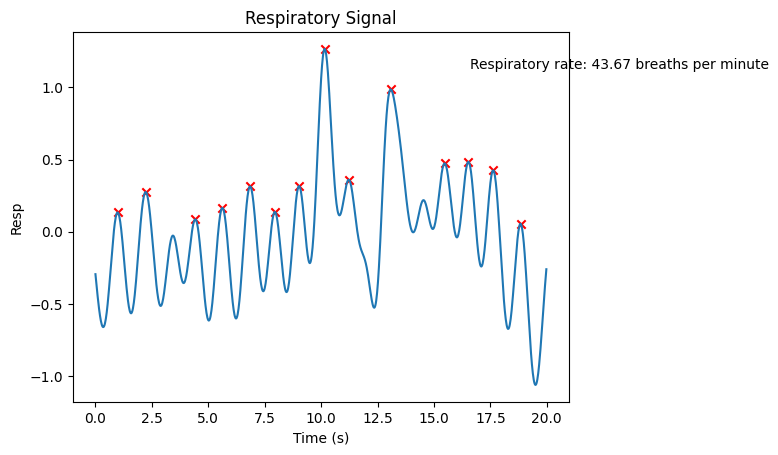

In [15]:
import matplotlib.pyplot as plt

# Plot the preprocessed signal
plt.plot(df['time'], df['resp'])

# Plot the detected peaks on the signal
plt.scatter(df['time'][peaks], df['resp'][peaks], c='r', marker='x')

# Add labels and a title to the plot
plt.xlabel('Time (s)')
plt.ylabel('Resp')
plt.title('Respiratory Signal')
plt.text(0.8, 0.9, f'Respiratory rate: {rr:.2f} breaths per minute', transform=plt.gca().transAxes)

# Show the plot
plt.show()



In [6]:
df_peaks = pd.DataFrame(peaks)
df_peaks.columns = ["sample"]
df_peaks['sample'] = round((df_peaks['sample'] + df_peaks['sample'].shift(-1))/2, 0)  # Average of two samples peak
df_peaks = df_peaks.drop(df_peaks.index[-1])

df_resp_rate = pd.DataFrame(rr_between_peaks)
df_resp_rate = pd.concat([df_peaks, df_resp_rate], axis=1)
df_resp_rate.columns = ["sample", "resp_rate"]
df_resp_rate1 = df_resp_rate[(df_resp_rate['resp_rate'] > 20) & (df_resp_rate['resp_rate'] < 65)]   #Delete abnormal data
df_resp_rate1.to_csv('C:/Users/bai/Desktop/resp_rate1.csv',index=False)

Infant 2

In [ ]:
data_dir = "C:/Users/bai/Desktop/database"
resp_record = wfdb.rdsamp(f"{data_dir}/infant2_resp")
resp_record2 = preprocessing.scale(resp_record[0])  #Z-score

resp_record2 = pd.DataFrame(resp_record2)
resp_record2.insert(0, 'timestamp', np.arange(0, len(resp_record2)*0.02, 0.02))
resp_record2.columns = ["time", "resp"]
resp_record2.insert(0, "sample", range(1, len(resp_record2) + 1))
resp_record2.to_csv('C:/Users/bai/Desktop/resp_record2.csv',index=False)

import pandas as pd
import numpy as np

# Load the respiratory signal data from the CSV file
df = pd.read_csv('C:/Users/bai/Desktop/resp_record2.csv')

# Remove any noise from the signal using a low-pass filter
# Butterworth filter
from scipy.signal import butter, filtfilt
lowcut = 0.1
highcut = 2
nyquist = 1.0 * 50
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(3, [low, high], btype='band')

# Find the peaks in the signal using a peak detection algorithm
from scipy.signal import find_peaks
peaks, _ = find_peaks(df['resp'], distance=50)

# Calculate the respiratory rate by finding the time between peaks
rr = 60 / np.mean(np.diff(df['time'][peaks]))
print(f'Respiratory rate: {rr} breaths per minute')

# Calculate the time difference between each peak
time_diff = np.diff(df['time'][peaks])

# Calculate the respiratory rate between each peak
rr_between_peaks = 60 / time_diff

# Print the respiratory rate between each peak
print(rr_between_peaks)


import matplotlib.pyplot as plt

# Plot the preprocessed signal
plt.plot(df['time'], df['resp'])

# Plot the detected peaks on the signal
plt.scatter(df['time'][peaks], df['resp'][peaks], c='r', marker='x')

# Add labels and a title to the plot
plt.xlabel('Time (s)')
plt.ylabel('Resp')
plt.title('Respiratory Signal')
plt.text(0.8, 0.9, f'Respiratory rate: {rr:.2f} breaths per minute', transform=plt.gca().transAxes)

# Show the plot
plt.show()

df_peaks = pd.DataFrame(peaks)
df_peaks.columns = ["sample"]
df_peaks['sample'] = round((df_peaks['sample'] + df_peaks['sample'].shift(-1))/2, 0)  # Average of two samples peak
df_peaks = df_peaks.drop(df_peaks.index[-1])

df_resp_rate = pd.DataFrame(rr_between_peaks)
df_resp_rate = pd.concat([df_peaks, df_resp_rate], axis=1)
df_resp_rate.columns = ["sample", "resp_rate"]
df_resp_rate2 = df_resp_rate[(df_resp_rate['resp_rate'] > 20) & (df_resp_rate['resp_rate'] < 65)]   #Delete abnormal data
df_resp_rate2.to_csv('C:/Users/bai/Desktop/resp_rate2.csv',index=False)


Infant 3

In [ ]:
data_dir = "C:/Users/bai/Desktop/database"
resp_record = wfdb.rdsamp(f"{data_dir}/infant3_resp")
resp_record3 = preprocessing.scale(resp_record[0])  #Z-score

resp_record3 = pd.DataFrame(resp_record3)
resp_record3.insert(0, 'timestamp', np.arange(0, len(resp_record3)*0.02, 0.02)[:7868296])
resp_record3.columns = ["time", "resp"]
resp_record3.insert(0, "sample", range(1, len(resp_record3) + 1))
resp_record3.to_csv('C:/Users/bai/Desktop/resp_record3.csv',index=False)

import pandas as pd
import numpy as np

# Load the respiratory signal data from the CSV file
df = pd.read_csv('C:/Users/bai/Desktop/resp_record3.csv')

# Remove any noise from the signal using a low-pass filter
# Butterworth filter
from scipy.signal import butter, filtfilt
lowcut = 0.1
highcut = 2
nyquist = 1.0 * 50
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(3, [low, high], btype='band')
df['resp'] = filtfilt(b, a, df['resp'])

# Find the peaks in the signal using a peak detection algorithm
from scipy.signal import find_peaks
peaks, _ = find_peaks(df['resp'], distance=50)

# Calculate the respiratory rate by finding the time between peaks
rr = 60 / np.mean(np.diff(df['time'][peaks]))
print(f'Respiratory rate: {rr} breaths per minute')

# Calculate the time difference between each peak
time_diff = np.diff(df['time'][peaks])

# Calculate the respiratory rate between each peak
rr_between_peaks = 60 / time_diff

# Print the respiratory rate between each peak
print(rr_between_peaks)


import matplotlib.pyplot as plt

# Plot the preprocessed signal
plt.plot(df['time'], df['resp'])

# Plot the detected peaks on the signal
plt.scatter(df['time'][peaks], df['resp'][peaks], c='r', marker='x')

# Add labels and a title to the plot
plt.xlabel('Time (s)')
plt.ylabel('Resp')
plt.title('Respiratory Signal')
plt.text(0.8, 0.9, f'Respiratory rate: {rr:.2f} breaths per minute', transform=plt.gca().transAxes)

# Show the plot
plt.show()

df_peaks = pd.DataFrame(peaks)
df_peaks.columns = ["sample"]
df_peaks['sample'] = round((df_peaks['sample'] + df_peaks['sample'].shift(-1))/2, 0)  # Average of two samples peak
df_peaks = df_peaks.drop(df_peaks.index[-1])

df_resp_rate = pd.DataFrame(rr_between_peaks)
df_resp_rate = pd.concat([df_peaks, df_resp_rate], axis=1)
df_resp_rate.columns = ["sample", "resp_rate"]
df_resp_rate3 = df_resp_rate[(df_resp_rate['resp_rate'] > 20) & (df_resp_rate['resp_rate'] < 65)]   #Delete abnormal data
df_resp_rate3.to_csv('C:/Users/bai/Desktop/resp_rate3.csv',index=False)


Infant 4

In [ ]:
data_dir = "C:/Users/bai/Desktop/database"
resp_record = wfdb.rdsamp(f"{data_dir}/infant4_resp")
resp_record4 = preprocessing.scale(resp_record[0])  #Z-score

resp_record4 = pd.DataFrame(resp_record4)
resp_record4.insert(0, 'timestamp', np.arange(0, len(resp_record4)*0.02, 0.02))
resp_record4.columns = ["time", "resp"]
resp_record4.insert(0, "sample", range(1, len(resp_record4) + 1))
resp_record4.to_csv('C:/Users/bai/Desktop/resp_record4.csv',index=False)

import pandas as pd
import numpy as np

# Load the respiratory signal data from the CSV file
df = pd.read_csv('C:/Users/bai/Desktop/resp_record4.csv')

# Remove any noise from the signal using a low-pass filter
# Butterworth filter
from scipy.signal import butter, filtfilt
lowcut = 0.1
highcut = 2
nyquist = 1.0 * 50
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(3, [low, high], btype='band')
df['resp'] = filtfilt(b, a, df['resp'])

# Find the peaks in the signal using a peak detection algorithm
from scipy.signal import find_peaks
peaks, _ = find_peaks(df['resp'], distance=50)

# Calculate the respiratory rate by finding the time between peaks
rr = 60 / np.mean(np.diff(df['time'][peaks]))
print(f'Respiratory rate: {rr} breaths per minute')

# Calculate the time difference between each peak
time_diff = np.diff(df['time'][peaks])

# Calculate the respiratory rate between each peak
rr_between_peaks = 60 / time_diff

# Print the respiratory rate between each peak
print(rr_between_peaks)


import matplotlib.pyplot as plt

# Plot the preprocessed signal
plt.plot(df['time'], df['resp'])

# Plot the detected peaks on the signal
plt.scatter(df['time'][peaks], df['resp'][peaks], c='r', marker='x')

# Add labels and a title to the plot
plt.xlabel('Time (s)')
plt.ylabel('Resp')
plt.title('Respiratory Signal')
plt.text(0.8, 0.9, f'Respiratory rate: {rr:.2f} breaths per minute', transform=plt.gca().transAxes)

# Show the plot
plt.show()

df_peaks = pd.DataFrame(peaks)
df_peaks.columns = ["sample"]
df_peaks['sample'] = round((df_peaks['sample'] + df_peaks['sample'].shift(-1))/2, 0)  # Average of two samples peak
df_peaks = df_peaks.drop(df_peaks.index[-1])

df_resp_rate = pd.DataFrame(rr_between_peaks)
df_resp_rate = pd.concat([df_peaks, df_resp_rate], axis=1)
df_resp_rate.columns = ["sample", "resp_rate"]
df_resp_rate4 = df_resp_rate[(df_resp_rate['resp_rate'] > 20) & (df_resp_rate['resp_rate'] < 65)]   #Delete abnormal data
df_resp_rate4.to_csv('C:/Users/bai/Desktop/resp_rate4.csv',index=False)


Infant 5

In [ ]:
data_dir = "C:/Users/bai/Desktop/database"
resp_record = wfdb.rdsamp(f"{data_dir}/infant5_resp")
resp_record5 = preprocessing.scale(resp_record[0])  #Z-score

resp_record5 = pd.DataFrame(resp_record5)
resp_record5.insert(0, 'timestamp', np.arange(0, len(resp_record5)*0.02, 0.02))
resp_record5.columns = ["time", "resp"]
resp_record5.insert(0, "sample", range(1, len(resp_record5) + 1))
resp_record5.to_csv('C:/Users/bai/Desktop/resp_record5.csv',index=False)

import pandas as pd
import numpy as np

# Load the respiratory signal data from the CSV file
df = pd.read_csv('C:/Users/bai/Desktop/resp_record5.csv')

# Remove any noise from the signal using a low-pass filter
# Butterworth filter
from scipy.signal import butter, filtfilt
lowcut = 0.1
highcut = 2
nyquist = 1.0 * 50
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(3, [low, high], btype='band')
df['resp'] = filtfilt(b, a, df['resp'])

# Find the peaks in the signal using a peak detection algorithm
from scipy.signal import find_peaks
peaks, _ = find_peaks(df['resp'], distance=50)

# Calculate the respiratory rate by finding the time between peaks
rr = 60 / np.mean(np.diff(df['time'][peaks]))
print(f'Respiratory rate: {rr} breaths per minute')

# Calculate the time difference between each peak
time_diff = np.diff(df['time'][peaks])

# Calculate the respiratory rate between each peak
rr_between_peaks = 60 / time_diff

# Print the respiratory rate between each peak
print(rr_between_peaks)


import matplotlib.pyplot as plt

# Plot the preprocessed signal
plt.plot(df['time'], df['resp'])

# Plot the detected peaks on the signal
plt.scatter(df['time'][peaks], df['resp'][peaks], c='r', marker='x')

# Add labels and a title to the plot
plt.xlabel('Time (s)')
plt.ylabel('Resp')
plt.title('Respiratory Signal')
plt.text(0.8, 0.9, f'Respiratory rate: {rr:.2f} breaths per minute', transform=plt.gca().transAxes)

# Show the plot
plt.show()

df_peaks = pd.DataFrame(peaks)
df_peaks.columns = ["sample"]
df_peaks['sample'] = round((df_peaks['sample'] + df_peaks['sample'].shift(-1))/2, 0)  # Average of two samples peak
df_peaks = df_peaks.drop(df_peaks.index[-1])

df_resp_rate = pd.DataFrame(rr_between_peaks)
df_resp_rate = pd.concat([df_peaks, df_resp_rate], axis=1)
df_resp_rate.columns = ["sample", "resp_rate"]
df_resp_rate5 = df_resp_rate[(df_resp_rate['resp_rate'] > 20) & (df_resp_rate['resp_rate'] < 65)]   #Delete abnormal data
df_resp_rate5.to_csv('C:/Users/bai/Desktop/resp_rate5.csv',index=False)


Infant 6

In [ ]:
data_dir = "C:/Users/bai/Desktop/database"
resp_record = wfdb.rdsamp(f"{data_dir}/infant6_resp")
resp_record6 = preprocessing.scale(resp_record[0])  #Z-score

resp_record6 = pd.DataFrame(resp_record6)
resp_record6.insert(0, 'timestamp', np.arange(0, len(resp_record6)*0.02, 0.02))
resp_record6.columns = ["time", "resp"]
resp_record6.insert(0, "sample", range(1, len(resp_record6) + 1))
resp_record6.to_csv('C:/Users/bai/Desktop/resp_record6.csv',index=False)

import pandas as pd
import numpy as np

# Load the respiratory signal data from the CSV file
df = pd.read_csv('C:/Users/bai/Desktop/resp_record6.csv')

# Remove any noise from the signal using a low-pass filter
# Butterworth filter
from scipy.signal import butter, filtfilt
lowcut = 0.1
highcut = 2
nyquist = 1.0 * 50
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(3, [low, high], btype='band')
df['resp'] = filtfilt(b, a, df['resp'])

# Find the peaks in the signal using a peak detection algorithm
from scipy.signal import find_peaks
peaks, _ = find_peaks(df['resp'], distance=50)

# Calculate the respiratory rate by finding the time between peaks
rr = 60 / np.mean(np.diff(df['time'][peaks]))
print(f'Respiratory rate: {rr} breaths per minute')

# Calculate the time difference between each peak
time_diff = np.diff(df['time'][peaks])

# Calculate the respiratory rate between each peak
rr_between_peaks = 60 / time_diff

# Print the respiratory rate between each peak
print(rr_between_peaks)


import matplotlib.pyplot as plt

# Plot the preprocessed signal
plt.plot(df['time'], df['resp'])

# Plot the detected peaks on the signal
plt.scatter(df['time'][peaks], df['resp'][peaks], c='r', marker='x')

# Add labels and a title to the plot
plt.xlabel('Time (s)')
plt.ylabel('Resp')
plt.title('Respiratory Signal')
plt.text(0.8, 0.9, f'Respiratory rate: {rr:.2f} breaths per minute', transform=plt.gca().transAxes)

# Show the plot
plt.show()

df_peaks = pd.DataFrame(peaks)
df_peaks.columns = ["sample"]
df_peaks['sample'] = round((df_peaks['sample'] + df_peaks['sample'].shift(-1))/2, 0)  # Average of two samples peak
df_peaks = df_peaks.drop(df_peaks.index[-1])

df_resp_rate = pd.DataFrame(rr_between_peaks)
df_resp_rate = pd.concat([df_peaks, df_resp_rate], axis=1)
df_resp_rate.columns = ["sample", "resp_rate"]
df_resp_rate6 = df_resp_rate[(df_resp_rate['resp_rate'] > 20) & (df_resp_rate['resp_rate'] < 65)]   #Delete abnormal data
df_resp_rate6.to_csv('C:/Users/bai/Desktop/resp_rate6.csv',index=False)


Infant 7

In [ ]:
data_dir = "C:/Users/bai/Desktop/database"
resp_record = wfdb.rdsamp(f"{data_dir}/infant7_resp")
resp_record7 = preprocessing.scale(resp_record[0])  #Z-score

resp_record7 = pd.DataFrame(resp_record7)
resp_record7.insert(0, 'timestamp', np.arange(0, len(resp_record7)*0.02, 0.02))
resp_record7.columns = ["time", "resp"]
resp_record7.insert(0, "sample", range(1, len(resp_record7) + 1))
resp_record7.to_csv('C:/Users/bai/Desktop/resp_record7.csv',index=False)

import pandas as pd
import numpy as np

# Load the respiratory signal data from the CSV file
df = pd.read_csv('C:/Users/bai/Desktop/resp_record7.csv')

# Remove any noise from the signal using a low-pass filter
# Butterworth filter
from scipy.signal import butter, filtfilt
lowcut = 0.1
highcut = 2
nyquist = 1.0 * 50
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(3, [low, high], btype='band')
df['resp'] = filtfilt(b, a, df['resp'])

# Find the peaks in the signal using a peak detection algorithm
from scipy.signal import find_peaks
peaks, _ = find_peaks(df['resp'], distance=50)

# Calculate the respiratory rate by finding the time between peaks
rr = 60 / np.mean(np.diff(df['time'][peaks]))
print(f'Respiratory rate: {rr} breaths per minute')

# Calculate the time difference between each peak
time_diff = np.diff(df['time'][peaks])

# Calculate the respiratory rate between each peak
rr_between_peaks = 60 / time_diff

# Print the respiratory rate between each peak
print(rr_between_peaks)


import matplotlib.pyplot as plt

# Plot the preprocessed signal
plt.plot(df['time'], df['resp'])

# Plot the detected peaks on the signal
plt.scatter(df['time'][peaks], df['resp'][peaks], c='r', marker='x')

# Add labels and a title to the plot
plt.xlabel('Time (s)')
plt.ylabel('Resp')
plt.title('Respiratory Signal')
plt.text(0.8, 0.9, f'Respiratory rate: {rr:.2f} breaths per minute', transform=plt.gca().transAxes)

# Show the plot
plt.show()

df_peaks = pd.DataFrame(peaks)
df_peaks.columns = ["sample"]
df_peaks['sample'] = round((df_peaks['sample'] + df_peaks['sample'].shift(-1))/2, 0)  # Average of two samples peak
df_peaks = df_peaks.drop(df_peaks.index[-1])

df_resp_rate = pd.DataFrame(rr_between_peaks)
df_resp_rate = pd.concat([df_peaks, df_resp_rate], axis=1)
df_resp_rate.columns = ["sample", "resp_rate"]
df_resp_rate7 = df_resp_rate[(df_resp_rate['resp_rate'] > 20) & (df_resp_rate['resp_rate'] < 65)]   #Delete abnormal data
df_resp_rate7.to_csv('C:/Users/bai/Desktop/resp_rate7.csv',index=False)


Infant 8

In [ ]:
data_dir = "C:/Users/bai/Desktop/database"
resp_record = wfdb.rdsamp(f"{data_dir}/infant8_resp")
resp_record8 = preprocessing.scale(resp_record[0])  #Z-score

resp_record8 = pd.DataFrame(resp_record8)
resp_record8.insert(0, 'timestamp', np.arange(0, len(resp_record8)*0.02, 0.02))
resp_record8.columns = ["time", "resp"]
resp_record8.insert(0, "sample", range(1, len(resp_record8) + 1))
resp_record8.to_csv('C:/Users/bai/Desktop/resp_record8.csv',index=False)

import pandas as pd
import numpy as np

# Load the respiratory signal data from the CSV file
df = pd.read_csv('C:/Users/bai/Desktop/resp_record8.csv')

# Remove any noise from the signal using a low-pass filter
# Butterworth filter
from scipy.signal import butter, filtfilt
lowcut = 0.1
highcut = 2
nyquist = 1.0 * 50
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(3, [low, high], btype='band')
df['resp'] = filtfilt(b, a, df['resp'])

# Find the peaks in the signal using a peak detection algorithm
from scipy.signal import find_peaks
peaks, _ = find_peaks(df['resp'], distance=50)

# Calculate the respiratory rate by finding the time between peaks
rr = 60 / np.mean(np.diff(df['time'][peaks]))
print(f'Respiratory rate: {rr} breaths per minute')

# Calculate the time difference between each peak
time_diff = np.diff(df['time'][peaks])

# Calculate the respiratory rate between each peak
rr_between_peaks = 60 / time_diff

# Print the respiratory rate between each peak
print(rr_between_peaks)


import matplotlib.pyplot as plt

# Plot the preprocessed signal
plt.plot(df['time'], df['resp'])

# Plot the detected peaks on the signal
plt.scatter(df['time'][peaks], df['resp'][peaks], c='r', marker='x')

# Add labels and a title to the plot
plt.xlabel('Time (s)')
plt.ylabel('Resp')
plt.title('Respiratory Signal')
plt.text(0.8, 0.9, f'Respiratory rate: {rr:.2f} breaths per minute', transform=plt.gca().transAxes)

# Show the plot
plt.show()

df_peaks = pd.DataFrame(peaks)
df_peaks.columns = ["sample"]
df_peaks['sample'] = round((df_peaks['sample'] + df_peaks['sample'].shift(-1))/2, 0)  # Average of two samples peak
df_peaks = df_peaks.drop(df_peaks.index[-1])

df_resp_rate = pd.DataFrame(rr_between_peaks)
df_resp_rate = pd.concat([df_peaks, df_resp_rate], axis=1)
df_resp_rate.columns = ["sample", "resp_rate"]
df_resp_rate8 = df_resp_rate[(df_resp_rate['resp_rate'] > 20) & (df_resp_rate['resp_rate'] < 65)]   #Delete abnormal data
df_resp_rate8.to_csv('C:/Users/bai/Desktop/resp_rate8.csv',index=False)


Infant 9

In [ ]:
data_dir = "C:/Users/bai/Desktop/database"
resp_record = wfdb.rdsamp(f"{data_dir}/infant9_resp")
resp_record9 = preprocessing.scale(resp_record[0])  #Z-score

resp_record9 = pd.DataFrame(resp_record9)
resp_record9.insert(0, 'timestamp', np.arange(0, len(resp_record9)*0.02, 0.02))
resp_record9.columns = ["time", "resp"]
resp_record9.insert(0, "sample", range(1, len(resp_record9) + 1))
resp_record9.to_csv('C:/Users/bai/Desktop/resp_record9.csv',index=False)

import pandas as pd
import numpy as np

# Load the respiratory signal data from the CSV file
df = pd.read_csv('C:/Users/bai/Desktop/resp_record9.csv')

# Remove any noise from the signal using a low-pass filter
# Butterworth filter
from scipy.signal import butter, filtfilt
lowcut = 0.1
highcut = 2
nyquist = 1.0 * 50
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(3, [low, high], btype='band')
df['resp'] = filtfilt(b, a, df['resp'])

# Find the peaks in the signal using a peak detection algorithm
from scipy.signal import find_peaks
peaks, _ = find_peaks(df['resp'], distance=50)

# Calculate the respiratory rate by finding the time between peaks
rr = 60 / np.mean(np.diff(df['time'][peaks]))
print(f'Respiratory rate: {rr} breaths per minute')

# Calculate the time difference between each peak
time_diff = np.diff(df['time'][peaks])

# Calculate the respiratory rate between each peak
rr_between_peaks = 60 / time_diff

# Print the respiratory rate between each peak
print(rr_between_peaks)


import matplotlib.pyplot as plt

# Plot the preprocessed signal
plt.plot(df['time'], df['resp'])

# Plot the detected peaks on the signal
plt.scatter(df['time'][peaks], df['resp'][peaks], c='r', marker='x')

# Add labels and a title to the plot
plt.xlabel('Time (s)')
plt.ylabel('Resp')
plt.title('Respiratory Signal')
plt.text(0.8, 0.9, f'Respiratory rate: {rr:.2f} breaths per minute', transform=plt.gca().transAxes)

# Show the plot
plt.show()

df_peaks = pd.DataFrame(peaks)
df_peaks.columns = ["sample"]
df_peaks['sample'] = round((df_peaks['sample'] + df_peaks['sample'].shift(-1))/2, 0)  # Average of two samples peak
df_peaks = df_peaks.drop(df_peaks.index[-1])

df_resp_rate = pd.DataFrame(rr_between_peaks)
df_resp_rate = pd.concat([df_peaks, df_resp_rate], axis=1)
df_resp_rate.columns = ["sample", "resp_rate"]
df_resp_rate9 = df_resp_rate[(df_resp_rate['resp_rate'] > 20) & (df_resp_rate['resp_rate'] < 65)]   #Delete abnormal data
df_resp_rate9.to_csv('C:/Users/bai/Desktop/resp_rate9.csv',index=False)


Infant 10

In [ ]:
data_dir = "C:/Users/bai/Desktop/database"
resp_record = wfdb.rdsamp(f"{data_dir}/infant10_resp")
resp_record10 = preprocessing.scale(resp_record[0])  #Z-score

resp_record10 = pd.DataFrame(resp_record10)
resp_record10.insert(0, 'timestamp', np.arange(0, len(resp_record10)*0.02, 0.02))
resp_record10.columns = ["time", "resp"]
resp_record10.insert(0, "sample", range(1, len(resp_record10) + 1))
resp_record10.to_csv('C:/Users/bai/Desktop/resp_record10.csv',index=False)

import pandas as pd
import numpy as np

# Load the respiratory signal data from the CSV file
df = pd.read_csv('C:/Users/bai/Desktop/resp_record10.csv')

# Remove any noise from the signal using a low-pass filter
# Butterworth filter
from scipy.signal import butter, filtfilt
lowcut = 0.1
highcut = 2
nyquist = 1.0 * 50
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(3, [low, high], btype='band')
df['resp'] = filtfilt(b, a, df['resp'])

# Find the peaks in the signal using a peak detection algorithm
from scipy.signal import find_peaks
peaks, _ = find_peaks(df['resp'], distance=50)

# Calculate the respiratory rate by finding the time between peaks
rr = 60 / np.mean(np.diff(df['time'][peaks]))
print(f'Respiratory rate: {rr} breaths per minute')

# Calculate the time difference between each peak
time_diff = np.diff(df['time'][peaks])

# Calculate the respiratory rate between each peak
rr_between_peaks = 60 / time_diff

# Print the respiratory rate between each peak
print(rr_between_peaks)


import matplotlib.pyplot as plt

# Plot the preprocessed signal
plt.plot(df['time'], df['resp'])

# Plot the detected peaks on the signal
plt.scatter(df['time'][peaks], df['resp'][peaks], c='r', marker='x')

# Add labels and a title to the plot
plt.xlabel('Time (s)')
plt.ylabel('Resp')
plt.title('Respiratory Signal')
plt.text(0.8, 0.9, f'Respiratory rate: {rr:.2f} breaths per minute', transform=plt.gca().transAxes)

# Show the plot
plt.show()

df_peaks = pd.DataFrame(peaks)
df_peaks.columns = ["sample"]
df_peaks['sample'] = round((df_peaks['sample'] + df_peaks['sample'].shift(-1))/2, 0)  # Average of two samples peak
df_peaks = df_peaks.drop(df_peaks.index[-1])

df_resp_rate = pd.DataFrame(rr_between_peaks)
df_resp_rate = pd.concat([df_peaks, df_resp_rate], axis=1)
df_resp_rate.columns = ["sample", "resp_rate"]
df_resp_rate10 = df_resp_rate[(df_resp_rate['resp_rate'] > 20) & (df_resp_rate['resp_rate'] < 65)]   #Delete abnormal data
df_resp_rate10.to_csv('C:/Users/bai/Desktop/resp_rate10.csv',index=False)


### **Merge and export files. Heart rate and respiratory rate.**

In [ ]:
### train data
train = df_resp_rate1.merge(df_heart_rate1, on="sample", how="inner")
train1 = train.drop("sample", axis=1)
#train1.to_csv("train1.csv", index=False)

train = df_resp_rate2.merge(df_heart_rate2, on="sample", how="inner")
train2 = train.drop("sample", axis=1)

train = df_resp_rate3.merge(df_heart_rate3, on="sample", how="inner")
train3 = train.drop("sample", axis=1)

train = df_resp_rate4.merge(df_heart_rate4, on="sample", how="inner")
train4 = train.drop("sample", axis=1)

train = df_resp_rate5.merge(df_heart_rate5, on="sample", how="inner")
train5 = train.drop("sample", axis=1)

train = df_resp_rate6.merge(df_heart_rate6, on="sample", how="inner")
train6 = train.drop("sample", axis=1)

train = df_resp_rate7.merge(df_heart_rate7, on="sample", how="inner")
train7 = train.drop("sample", axis=1)

### test data
test = df_resp_rate8.merge(df_heart_rate8, on="sample", how="inner")
test8 = test.drop("sample", axis=1)

test = df_resp_rate9.merge(df_heart_rate9, on="sample", how="inner")
test9 = test.drop("sample", axis=1)

test = df_resp_rate10.merge(df_heart_rate10, on="sample", how="inner")
test10 = test.drop("sample", axis=1)

# mearge
df_train = [train1, train2, train3, train4, train5, train6, train7]
df_test = [test8, test9, test10]

# merged_df_train = pd.concat(df_train, axis=1)
# merged_df_test = pd.concat(df_test, axis=1)
merged_df_train = pd.concat(df_train)
merged_df_test = pd.concat(df_test)

###Delete abnormal data

# Check for outliers in the first column using Z-score
z_score = np.abs(merged_df_train.iloc[:,0] - merged_df_train.iloc[:,0].mean()) / merged_df_train.iloc[:,0].std()
outlier_index1 = z_score > 1 # assume outliers are defined as values more than 1 standard deviations away from the mean
# Check for outliers in the second column using Z-score
z_score = np.abs(merged_df_train.iloc[:,1] - merged_df_train.iloc[:,1].mean()) / merged_df_train.iloc[:,1].std()
outlier_index2 = z_score > 1 # assume outliers are defined as values more than 1 standard deviations away from the mean
# Combine the outlier indexes
outlier_index = outlier_index1 | outlier_index2
# Drop the rows with outliers
merged_df_train = merged_df_train.drop(merged_df_train[outlier_index].index)


# Check for outliers in the first column using Z-score
z_score = np.abs(merged_df_test.iloc[:,0] - merged_df_test.iloc[:,0].mean()) / merged_df_test.iloc[:,0].std()
outlier_index1 = z_score > 1 # assume outliers are defined as values more than 1 standard deviations away from the mean
# Check for outliers in the second column using Z-score
z_score = np.abs(merged_df_test.iloc[:,1] - merged_df_test.iloc[:,1].mean()) / merged_df_test.iloc[:,1].std()
outlier_index2 = z_score > 1 # assume outliers are defined as values more than 1 standard deviations away from the mean
# Combine the outlier indexes
outlier_index = outlier_index1 | outlier_index2
# Drop the rows with outliers
merged_df_test = merged_df_test.drop(merged_df_test[outlier_index].index)


merged_df_train.to_csv("C:/Users/bai/Desktop/train_infant1-7.csv", index=False)
merged_df_test.to_csv("C:/Users/bai/Desktop/test_infant8-10.csv", index=False)

merged_df_train.to_csv("/content/sample_data/train_infant1-7.csv", index=False)
merged_df_test.to_csv("/content/sample_data/test_infant8-10.csv", index=False)

### **Model Training**

### **Import required modules**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

### **Load and Split data**

In [ ]:
# Load data
url = "/content/sample_data/train_infant1-7.csv"
df_train_data = pd.read_csv(url)
url = "/content/sample_data/test_infant8-10.csv"
df_test_data = pd.read_csv(url)

# Convert data to numpy arrays
X_train1 = np.array(df_train_data['resp_rate']).reshape(-1, 1)
X_train = np.nan_to_num(X_train1)

X_test1 = np.array(df_test_data['resp_rate']).reshape(-1, 1)
X_test = np.nan_to_num(X_test1)

y_train1 = np.array(df_train_data['heart_rate'])
y_train = np.nan_to_num(y_train1)

y_test1 = np.array(df_test_data['heart_rate'])
y_test = np.nan_to_num(y_test1)

### **Train model Linear Regression and Evaluate Performance**

In [ ]:
# Create an instance of the LinearRegression model
model = LinearRegression()

# Fit the model to the data (x_train and y_train are the training data)
model.fit(X_train, y_train)

# Make predictions on the test data (x_test is the test data)
y_pred = model.predict(X_test)

# Calculate the MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calculate the RMSE
rmse = np.sqrt(mse)
print("RMSE:", rmse)

### **Train model SVR**

In [ ]:
# Create an SVR object and train it on the training data
svr = SVR(kernel='linear', C=1.0, epsilon=0.1)
svr.fit(X_train, y_train)

# Use the trained SVR to predict the heart rate on the test data
y_pred = svr.predict(X_test)

### **Evaluate performance**

In [ ]:
# Calculate model accurency

# Calculate the MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calculate the RMSE
rmse = np.sqrt(mse)
print("RMSE:", rmse)

### **Hyperparameter tuning SVR**

In [ ]:
parameters = {'C': [0.1, 1.0, 10], 'kernel': ['linear', 'rbf'], 'epsilon': [0.1, 0.2, 0.3]}
clf = GridSearchCV(svr, parameters, cv=2)
clf.fit(X_train, y_train)
results = clf.cv_results_
results = pd.DataFrame.from_dict(results)
results

In [ ]:
results[['param_C', 'param_kernel', 'param_epsilon', 'mean_test_score']]

### **Retrain the model with the best hyperparameter**

In [ ]:
best_param = clf.best_params_
print('best param: ', best_param)
svr.set_params(**best_param)
svr.fit(X_train, y_train)

### **Evaluate model performancev after hyperparamter tuning**

In [ ]:
# Generate predictions
y_pred = svr.predict(X_test)

#Calculate model accurency
accurancy = svr.score(X_test, y_test)
print("Accurancy:", accurancy)

# Calculate the MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calculate the RMSE
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Evaluate by means of accuracy
print('Model CV accuracy: ', results['mean_test_score'].iloc[2])  
print('Parameter used:', best_param)